<a href="https://colab.research.google.com/github/Qen-byte/ML-with-python/blob/main/dogs__cats_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to your dataset
# Update these paths to match your actual file structure
train_dir = '/content/drive/MyDrive/Dataset/training_set'
test_dir = '/content/drive/MyDrive/Dataset/test_set'

# Print the directory structure to verify
print("Training directory contents:", os.listdir(train_dir))
print("Testing directory contents:", os.listdir(test_dir))

Training directory contents: ['cats', 'dogs']
Testing directory contents: ['dogs', 'cats']


In [ ]:
# Set up data generators with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Image dimensions to use
img_width, img_height = 150, 150
batch_size = 32

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Specify this is the training subset
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Specify this is the validation subset
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Check the class mappings
print("Class mappings (training):", train_generator.class_indices)

Found 5932 images belonging to 2 classes.
Found 1483 images belonging to 2 classes.
Found 2006 images belonging to 2 classes.
Class mappings (training): {'cats': 0, 'dogs': 1}


Training images: 5932
Validation images: 1483
Testing images: 2006


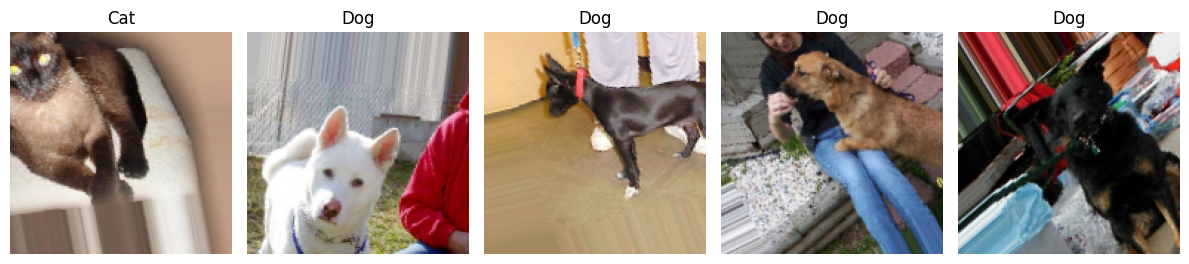

In [ ]:
# Count images in each set
print(f"Training images: {train_generator.samples}")
print(f"Validation images: {validation_generator.samples}")
print(f"Testing images: {test_generator.samples}")

# Visualize some sample images from the training set
def visualize_sample_images():
    """Visualize sample images from the training set"""
    plt.figure(figsize=(12, 8))

    for i, (images, labels) in enumerate(train_generator):
        for j in range(min(5, len(images))):
            plt.subplot(1, 5, j + 1)
            plt.imshow(images[j])

            # Get class name based on label value
            class_name = 'Cat' if labels[j] == 0 else 'Dog'  # Adjust based on your class indices
            plt.title(class_name)
            plt.axis('off')

        if i == 0:  # Just take the first batch
            break

    plt.tight_layout()
    plt.show()

visualize_sample_images()

In [ ]:
# Build the CNN model
def build_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Fourth convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Flatten and fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,456,577 (13.19 MB)

 Trainable params: 3,454,849 (13.18 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [ ]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.5620 - loss: 0.9554 